<a href="https://colab.research.google.com/github/tamirmal/tau_dl_proj/blob/master/HW1_LeNET5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install ipdb
import ipdb

%tensorflow_version 2.x
import datetime, os

def print_net_trainable_parameters(net):
    params = list(net.parameters())
    print(len(params))
    for p in params:
      if p.requires_grad:
        print(p.size())


  Created wheel for ipdb: filename=ipdb-0.12.2-cp36-none-any.whl size=9171 sha256=e2918c1d900319bb1131524b19f692aab73e036b59885da918eecd2230c5489d
  Stored in directory: /root/.cache/pip/wheels/7a/00/07/c906eaf1b90367fbb81bd840e56bf8859dbd3efe3838c0b4ba
Successfully built ipdb
TensorFlow 2.x selected.


In [0]:
%load_ext tensorboard

!rm -fr logs
!mkdir logs
%tensorboard --logdir logs


from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='logs/')


0it [00:00, ?it/s]

26427392it [00:02, 13185218.12it/s]                              


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 86816.56it/s]                            
0it [00:00, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


4423680it [00:01, 4027512.50it/s]                             
0it [00:00, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


8192it [00:00, 32189.76it/s]            

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images shape on batch size = torch.Size([128, 1, 32, 32])
labels shape on batch size = torch.Size([128])
tensor([[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         ...,
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]])


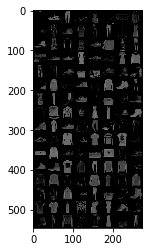

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.datasets.mnist import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

#from google.colab import drive
#drive.mount('/content/drive')
# dataset from : https://github.com/zalandoresearch/fashion-mnist

N_batch = 128

means = 0.5
deviations = means
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (1.0,))])

#transform=transforms.Compose([
#  transforms.Resize((32, 32)),
#  transforms.ToTensor()])

data_train = FashionMNIST('./',
    download=True,
    transform=transform)
data_test = FashionMNIST('./',
    train=False,
    download=True,
    transform=transform)
data_train_loader = DataLoader(data_train, batch_size=N_batch, shuffle=True, num_workers=4)
data_test_loader = DataLoader(data_test, batch_size=1024, num_workers=4)

## print some samples for sanity check
## (https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
train_iter = iter(data_train_loader)
images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

grid = torchvision.utils.make_grid(images)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

print(images[0])

![LeNet5](https://www.researchgate.net/profile/Gabriel_Falcao/publication/321665783/figure/fig2/AS:635289152282624@1528476145313/The-architecture-of-LeNet-5-23-a-CNN-used-for-digits-recognition-for-the-MNIST-dataset.png)

In [0]:
N_epochs = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# train 1 epoch, epoch = sweep over all examples in train set
# in iterations, each iteration trains over a minibatch
def train_net(net, optimizer, epoch):
  net.to(device)
  net.train() # set at train mode, will activate dropout layers or similar stuff that are valid only for train
  
  n_minibatches ,running_loss, running_correct = 0, 0, 0
  no_dropout_correct = 0
  for i, data in enumerate(data_train_loader):
    images, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    output = net(images)
    loss = criterion(output, labels)
    loss.backward()   # backprop the gradients - DOES NOT UPDATE
    optimizer.step()  # apply the gradient update
                      # notice how loss.backward and optimizer.step are separate! beacuse update is based on a rule
                      # that might be different for each optimizer (Adam, Momentum etc.) but the gradients are the same
    n_minibatches += 1
    running_loss += loss.item()
    running_correct += (torch.max(output, 1)[1].view(labels.size()) == labels).sum().item()

    if 'dropout' in net.name:
      net.eval()
      output = net(images)
      no_dropout_correct += (torch.max(output, 1)[1].view(labels.size()) == labels).sum().item()
      net.train()

  # end of for

  # print statistics
  N_total = N_batch*n_minibatches
  print("epoch {} loss {} train_set acc {}%".format(epoch, running_loss / N_total, 100*(running_correct / N_total)))
  if 'dropout' in net.name:
    print("epoch {} w/o dropout train_set acc {}%".format(epoch, 100*(no_dropout_correct / N_total)))

  writer.add_scalar(net.name+'/Loss/train', running_loss / N_total, epoch)
  writer.add_scalar(net.name+'/Accuracy/train', 100*(running_correct / N_total), epoch)
  writer.add_scalar(net.name+'/Accuracy/train-no-dropout', 100*(no_dropout_correct / N_total), epoch)
  # end of function

def test_net(net):
    net.eval() # put in eval mode, disable dropout etc.
    total_correct = 0
    avg_loss = 0.0
    for i, data in enumerate(data_test_loader):
        images, labels = data[0].to(device), data[1].to(device)
        output = net(images)
        avg_loss += criterion(output, labels).sum()
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum()
    # end of for
    avg_loss /= len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss.item(), 100*(float(total_correct) / len(data_test))))
    writer.add_scalar(net.name+'/Loss/test', avg_loss.item(), epoch)
    writer.add_scalar(net.name+'/Accuracy/test', 100*(float(total_correct) / len(data_test)), epoch)
  # end of function


In [0]:
import torch.optim as optim

## pyTorch first tuturial implements this network
## https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py

class LeNet5(nn.Module):
# As in http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf
  
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def __init__(self, regulizer_type=None):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # tuturial had 6x6x16, but i think it should be 5x5x16
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        if regulizer_type is None:
          self.name = 'vanilla_lenet5'
        elif regulizer_type == 'dropout':
          self.name = 'dropout_lenet5'
          self.dropout1 = nn.Dropout(0.2) # lower p for conv layers
          self.dropout2 = nn.Dropout(0.2)
          self.dropout3 = nn.Dropout(0.5)
          self.dropout4 = nn.Dropout(0.5)
        elif regulizer_type == 'BN':
          self.name = 'BN_lenet5'
          self.bn1 = nn.BatchNorm2d(6)
          self.bn2 = nn.BatchNorm2d(16)
          self.bn3 = nn.BatchNorm1d(120) # trying WITH BN in fully conntected, however I think its not really needed
          self.bn4 = nn.BatchNorm1d(84)
        elif regulizer_type == 'WD':
          self.name = 'WD_lenet5'

    def forward(self, x):     
        pool = F.max_pool2d
        # pool = F.avg_pool2d
        activation = F.relu
        #activation = F.tanh

        ### CONV1 block ###
        x = self.conv1(x)
        if self.name == 'BN_lenet5':
          x = self.bn1(x)
        elif self.name == 'dropout_lenet5':
          x = self.dropout1(x)
        x = pool(activation(x), 2)

        ### CONV2 block ###
        x = self.conv2(x)
        if self.name == 'BN_lenet5':
          x = self.bn2(x)
        elif self.name == 'dropout_lenet5':
          x = self.dropout2(x)
        x = pool(activation(x), 2)

        x = x.view(-1, self.num_flat_features(x))

        ### FC1 ###
        x = self.fc1(x)
        if self.name == 'BN_lenet5':
          x = self.bn3(x)
        elif self.name == 'dropout_lenet5':
          x = self.dropout3(x)
        x = activation(x)

        ### FC2 ###
        x = self.fc2(x)
        if self.name == 'BN_lenet5':
          x = self.bn4(x)
        elif self.name == 'dropout_lenet5':
          x = self.dropout4(x)
        x = activation(x)

        ### FC3 & Softmax ###
        x = F.softmax(self.fc3(x))
        return x

print("Print the network trainable parameters")
vanilla_LeNet5 = LeNet5()
print(vanilla_LeNet5)
print_net_trainable_parameters(vanilla_LeNet5)

criterion = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(vanilla_LeNet5.parameters(), lr=0.01, momentum=0.9)
optimizer_adam = optim.Adam(vanilla_LeNet5.parameters(), lr=0.001)


Print the network trainable parameters
LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
10
torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


In [0]:
for epoch in range(1, N_epochs):
    train_net(vanilla_LeNet5, optimizer_sgd, epoch)
    test_net(vanilla_LeNet5)

for epoch in range(N_epochs, 2*N_epochs):
    train_net(vanilla_LeNet5, optimizer_adam, epoch)
    test_net(vanilla_LeNet5)


In [0]:
lenet5dropout = LeNet5(regulizer_type='dropout')
optimizer_sgd = optim.SGD(lenet5dropout.parameters(), lr=0.01, momentum=0.9)
#optimizer_sgd = optim.SGD(lenet5dropout.parameters(), lr=0.01)
optimizer_adam = optim.Adam(lenet5dropout.parameters(), lr=0.001)

In [0]:
N_epochs = 50

for epoch in range(1, N_epochs):
    train_net(lenet5dropout, optimizer_sgd, epoch)
    test_net(lenet5dropout)

for epoch in range(N_epochs, 2*N_epochs):
    train_net(lenet5dropout, optimizer_adam, epoch)
    test_net(lenet5dropout)


In [0]:
lenet5bn = LeNet5(regulizer_type='BN')
optimizer_sgd = optim.SGD(lenet5bn.parameters(), lr=0.01, momentum=0.9)
optimizer_adam = optim.Adam(lenet5bn.parameters(), lr=0.001)

In [0]:
N_epochs = 50

for epoch in range(1, 100):
    train_net(lenet5bn, optimizer_sgd, epoch)
    test_net(lenet5bn)

for epoch in range(100, 150):
    train_net(lenet5bn, optimizer_adam, epoch)
    test_net(lenet5bn)


In [0]:
lenet5weight_decay = LeNet5(regulizer_type='WD')
optimizer_sgd = optim.SGD(lenet5weight_decay.parameters(), lr=0.01, momentum=0.9, weight_decay=0.1)
optimizer_adam = optim.Adam(lenet5weight_decay.parameters(), lr=0.001, weight_decay=0.1)

N_epochs = 50

for epoch in range(1, N_epochs):
    train_net(lenet5weight_decay, optimizer_sgd, epoch)
    test_net(lenet5weight_decay)

for epoch in range(N_epochs, 2*N_epochs):
    train_net(lenet5weight_decay, optimizer_adam, epoch)
    test_net(lenet5weight_decay)
